In [ ]:
# If we were to take another piece of context beforehand there is way too much storage of prior weights and thus this increase
# will lead to an explosion by a scaling factor of 27 or the size of your alphabet
# n-grams and not bigrams will lead to 27^n scaling within our scale and thus is not feasible

In [1]:
# Implementation of https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

# Words with similar semantic meaning will be placed closely together, the modelling approach is identical to our bigram model
# The network can place nodes closely to eachother and knowledge can be transferred to eachother
# E.g cats and dogs can be plaaced within the same context of sentences

# C matrix is a look up table that has the index of the row for each word - we get the n dimensional vector that corresponds to that word

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 

In [5]:
words = open("names.txt", "r").read().splitlines()
print(len(words))
words[:5]

32033


['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [7]:

characters = sorted(list(set("".join(words))))

# Creating both mappings from string to integer and from integer to string
# Setting "." as our start and end special character
stoi = {s:i+1 for i, s in enumerate(characters)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}

In [125]:
# Creating our training dataset by adding a block size for context window to predict the next character
# Our block size defines how many characters of context we take
block_size = 3

X, Y = [], []
for word in words:
    # Create the array for our context, to keep track of the previous characters
    context = [0] * block_size

    for character in word:
        # We get the character in the word
        index = stoi[character]
        #Add context and index
        X.append(context)
        Y.append(index)
        # Crop context and enter the new index
        context = context[1:] + [index]

# We are adding all the individual examples and all the labels
X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape
Y.shape

torch.Size([196113])

In [202]:
C = torch.randn((27, 2))

# These two methods are exactly the same in terms of indexing
F.one_hot(torch.tensor(5), num_classes=27).float() @ C
C[5]

# We can repeat any row as many times as we want using tensors
C[[6, 7, 8]]
# We can also index using multi dimensional tensors

tensor([[ 0.9924, -0.1618],
        [-1.4025, -1.3149],
        [-1.0956, -0.8394]])

In [203]:
# If we have X as our dataset which is indexing our C which will contain the n-dimensional vector representation for that
# characters 
# The great thing ab out pytorch is that we can index using this multidimensional array
C.shape # torch.Size([27, 2])
X.shape # torch.Size([13, 3])

# For all of the 13 index values we are indexing 3 times - since all 13 rows have size 3 of indexes
# and what we index returns a 2x1 array
C[X].shape
emb = C[X]
emb.shape

torch.Size([196113, 3, 2])

In [204]:
# We have 6 inputs and the number of neurons aer up to us
W1 = torch.randn((6, 100))
b1 = torch.rand(100)

In [205]:
# We hae a 13 x 3 x 2 size trying to multiply by a 6 x 100 but we need to combine 13x6 to do this matrix multiplication
# We need to concatenate torch.cat and we can concatenate a given dimension

# Split our tensor on the first dimension so that we get 3 different ones and then we bind it on the second dimension to get it all together
# torch.cat(torch.unbind(emb, 1), 1)

# Each tensor has underlying storage, they are all stored as a one dimensional vector, using .view()
# We can manipulate how that one dimensional sequence is interpreted - no memory is being changed or copied
# view() just updates internal attributes to alter its representation, offset, strides and shapes

# .view() gives the same concatenation and unbind operation
# emb = emb.view(13, 6)

# This means that it will work for any embedding size
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
h

tensor([[-0.3213,  0.4724, -0.8865,  ...,  0.6951,  0.9865,  0.9894],
        [-0.8455, -0.9354,  0.9890,  ...,  0.4013,  0.9869,  0.9998],
        [ 0.9066,  0.9921,  0.4076,  ..., -0.7417, -0.8615, -0.9798],
        ...,
        [ 0.8588,  0.9773, -0.9975,  ...,  0.8897,  0.9544,  0.9746],
        [ 0.3512,  0.2319, -0.9303,  ...,  0.9994,  0.9996,  0.9978],
        [ 0.9076,  0.8650, -0.9904,  ...,  0.9897,  0.9767,  0.9986]])

In [206]:
h.shape

torch.Size([196113, 100])

In [207]:
# Final layer
W2 = torch.randn((100, 27))
b2 = torch.rand(27)
logits = h @ W2 + b2

"""# All of these below can easily be replaced by cross_entropy
counts = logits.exp()
# These probabilities are the softmax
probability = counts / counts.sum(1, keepdim=True)
# These here are the cross entropy loss - teh average of the logged softmax
nll = -probability[torch.arange(36), Y].log().mean()
nll"""

# By just using the crossentropy - the backwards pass is far more efficient since we can derive the whole expression
# which will typically be simplified, the kernel will be simplified, instead of having to derive all the separate components of the function
F.cross_entropy(logits, Y)

tensor(13.3928)

In [208]:
parameters = [C, W1, b1, W2, b2]
# Number of elements in each tensor and summing all of them
num_parameters = sum([p.nelement() for p in parameters])
for p in parameters:
    p.requires_grad = True

In [209]:
learning_rate_exponents = torch.linspace(-3, 0, 1000)
learning_rate_exponents = reversed(10**learning_rate_exponents)
# learning_rate_exponents = 10**learning_rate_exponents
# Using learning rate exponents linspace instead of the linear ones
# in the beginning will be very very high learning rate and step to a far lower learning rate


In [210]:
# Each iteration takes quite a bit of time
# In practice we do it in many batches of the data, randomly select some portion of the dataset adn only  forward backward and update
# On that mini batch, by doing minibatches it is done much quicker
# However since we are doing minibatches the quality of our gradient direction is not as reliable
# Much better to have an approximate gradient with more steps than teh exact gradient adn fewer steps

learning_rates = []
losses = []

# torch randint
for _ in range(1000):
    # Constructing a minibatch - we pick 32 random numbers (given this is our minibatch size)
    # and they will pick a random index between 0 and the match size of X
    indexes = torch.randint(0, X.shape[0], (32,))

    # we have X.shape[0], 3, 2 but if we index X with 32 indexes we will get 32, 3, 2
    emb = C[X[indexes]]
    # .view() is far more optimised than concat and merge
    # To make it more efficient we can also use softmax here
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2
    # We have to index the exact same Y output values
    loss = F.cross_entropy(logits, Y[indexes])

    print(loss.item())

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = learning_rate_exponents[_]
    for p in parameters:
        p.data += lr * -p.grad

    learning_rates.append(lr)
    losses.append(loss.item())
    

12.453705787658691
10.811878204345703
8.336875915527344
12.06480598449707
15.23023509979248
20.516761779785156
15.059408187866211
17.051843643188477
11.899259567260742
11.96068000793457
13.066261291503906
17.522260665893555
15.604362487792969
12.220227241516113
11.925984382629395
11.054973602294922
12.545722961425781
11.65523910522461
12.32766342163086
11.14150333404541
10.194191932678223
7.1567792892456055
9.248258590698242
10.577554702758789
8.879773139953613
8.97998332977295
8.60169506072998
9.313952445983887
8.482817649841309
8.083624839782715
8.744386672973633
7.800523281097412
7.50065803527832
8.825799942016602
7.918724060058594
8.491667747497559
6.832668304443359
9.374856948852539
8.148520469665527
8.094137191772461
7.11245059967041
8.117870330810547
8.76223087310791
7.792881965637207
10.457620620727539
9.271906852722168
7.638846397399902
7.521217346191406
5.719934940338135
6.324648857116699
6.0843963623046875
6.369268417358398
5.380323886871338
6.266887187957764
5.4831442832946

In [211]:
learning_rates

[tensor(1.),
 tensor(0.9931),
 tensor(0.9863),
 tensor(0.9795),
 tensor(0.9727),
 tensor(0.9660),
 tensor(0.9594),
 tensor(0.9528),
 tensor(0.9462),
 tensor(0.9397),
 tensor(0.9332),
 tensor(0.9268),
 tensor(0.9204),
 tensor(0.9140),
 tensor(0.9077),
 tensor(0.9015),
 tensor(0.8953),
 tensor(0.8891),
 tensor(0.8830),
 tensor(0.8769),
 tensor(0.8708),
 tensor(0.8648),
 tensor(0.8589),
 tensor(0.8530),
 tensor(0.8471),
 tensor(0.8412),
 tensor(0.8355),
 tensor(0.8297),
 tensor(0.8240),
 tensor(0.8183),
 tensor(0.8127),
 tensor(0.8071),
 tensor(0.8015),
 tensor(0.7960),
 tensor(0.7905),
 tensor(0.7850),
 tensor(0.7796),
 tensor(0.7743),
 tensor(0.7689),
 tensor(0.7636),
 tensor(0.7584),
 tensor(0.7531),
 tensor(0.7480),
 tensor(0.7428),
 tensor(0.7377),
 tensor(0.7326),
 tensor(0.7275),
 tensor(0.7225),
 tensor(0.7176),
 tensor(0.7126),
 tensor(0.7077),
 tensor(0.7028),
 tensor(0.6980),
 tensor(0.6932),
 tensor(0.6884),
 tensor(0.6837),
 tensor(0.6789),
 tensor(0.6743),
 tensor(0.6696),
 

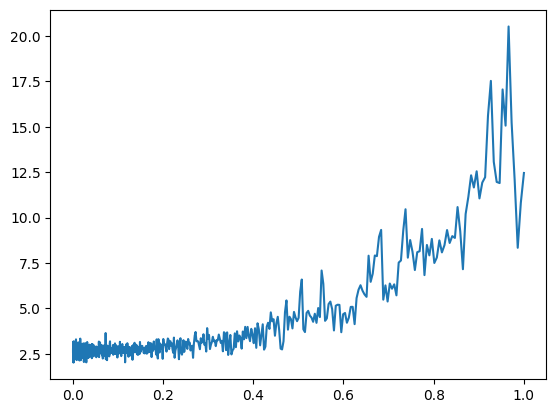

In [212]:
# We can plot our learning rate against the loss that we have and find the dip within our graph to find a good learning rate
plt.plot(learning_rates, losses)

In [ ]:
# If we check our dev and trainnig set and they have about hte same loss then we know that we can expect our network
# to be underfitting and thus we can scale it up as it is not powerful enough
# we can expect to scale up the network and see measurable improvements in bias

# If our batch size is too low we might have too much noise and not get a good enough representation of our data
# adn thus we might just be osciallating, we might want to increase our batch size
# we can also converge using learning rate decay at the end

# The vector representations could be a potentail bottleneck taht we are cramming far too many words in two dimensions                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
# Plotting the log of the loss prevents a hockey stick appearance and is far easier to analyse
# Creating a table of hyper parameters to run lots of experiments is a far better idea

# Once you notice the dev / training performance we know that it will end up overfitting to our training set

In [ ]:
# @torch.no_grad() decorator prevents any gradient trackin whenever you are doing any loss calculation for any of hte splits
